## Mini-project for LLM course

### Requirements

In [43]:
"""!pip install os
!pip install pandas
!pip install dotenv
!pip install random
!pip install openai
!pip install langchain_core
!pip install langchain_ollama"""

'!pip install os\n!pip install pandas\n!pip install dotenv\n!pip install random\n!pip install openai\n!pip install langchain_core\n!pip install langchain_ollama'

In [68]:
import pandas as pd 
import random
import os 
import ollama
from dotenv import load_dotenv
from openai import OpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from tqdm import tqdm 
import json
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [45]:
def read_xl_wic_file(file_path):
    """
    Reads XL-WiC format txt file and converts to DataFrame.
    Format: target_word \t PoS \t start_idx1 \t end_idx1 \t start_idx2 \t end_idx2 \t example1 \t example2 \t label

    The files follow a tab-separated format:
    target_word <tab> PoS <tab> start-char-index_1 <tab> end-char-index_1 <tab> start-char-index_2 <tab> end-char-index_2 <tab> example_1 <tab> example_2 <tab> label

    - "target_word": the target word which is present in both examples.
    - "PoS": the Part-of-Speech tag of the target word (either "N": noun or "V": verb).
    - "start-index_i": indicates the start char index of target_word in "i"th example. 
    - "end-index_i": indicates the end char index of target_word in "i"th example. 
    - "example_i": corresponds to the "i"th example.
    - "label": can be 1 or 0 depending on whether the intended sense of the target word is the same in both examples (1) or not (0).
    """
    columns = [
        'target_word', 'pos', 
        'start_idx1', 'end_idx1', 
        'start_idx2', 'end_idx2',
        'example1', 'example2', 
        'label'
    ]
    
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            row = [item.strip() for item in line.split('\t')]
            if len(row) == len(columns):
                # Convert indices and label to integers
                row[2:6] = [int(x) for x in row[2:6]]  # Convert all indices
                row[-1] = int(row[-1])  # Convert label
                data.append(row)
    
    return pd.DataFrame(data, columns=columns)

def sample_xl_wic_pairs(df, n_samples=100, seed=42):
    """
    Samples random word pairs from XL-WiC dataset and formats them for LLM evaluation
    """
    n_samples_per_label = n_samples // 2
    if seed:
        random.seed(seed)
        np.random.seed(seed)

    # Ensure balanced sampling for each label
    balanced_samples = []
    for label in df['label'].unique():
        label_samples = df[df['label'] == label].sample(n=n_samples_per_label, random_state=seed)
        balanced_samples.append(label_samples)
    combined_samples = pd.concat(balanced_samples).sample(frac=1, random_state=seed)

    formatted_samples = []
    for _, row in combined_samples.iterrows():
        sample_dict = {
            'word': row['target_word'],
            'pos': 'Noun' if row['pos'] == 'N' else 'Verb',
            'sentence1': row['example1'],
            'sentence2': row['example2'],
            'true_label': row['label'],
            'meaning': 'same' if row['label'] == 1 else 'different'
        }
        formatted_samples.append(sample_dict)

    return formatted_samples


In [46]:
df = read_xl_wic_file('xlwic_datasets/xlwic_datasets/wic_english/train_en.txt')
samples = sample_xl_wic_pairs(df, n_samples=20)
# Checking how dataset is constructed
for sample in samples:
    print(f"\nTarget word: {sample['word']} ({sample['pos']})")
    print(f"Sentence 1: {sample['sentence1']}")
    print(f"Sentence 2: {sample['sentence2']}")
    print(f"True label: {sample['meaning']} meaning ({sample['true_label']})")


Target word: erase (Verb)
Sentence 1: Please erase the formula on the blackboard -- it is wrong!
Sentence 2: The Turks erased the Armenians in 1915.
True label: different meaning (0)

Target word: feel (Noun)
Sentence 1: She has a feel for music.
Sentence 2: He has a feel for animals.
True label: same meaning (1)

Target word: tell (Verb)
Sentence 1: Tell me what is bothering you.
Sentence 2: Ellen told Helen how to avoid the crowd.
True label: same meaning (1)

Target word: play (Verb)
Sentence 1: Play the stock market.
Sentence 2: Who's playing now?
True label: different meaning (0)

Target word: top (Noun)
Sentence 1: I bought this top as it matches my jeans.
Sentence 2: A relief pitcher took over in the top of the fifth.
True label: different meaning (0)

Target word: development (Noun)
Sentence 1: The development and printing of his pictures took only two hours.
Sentence 2: After he saw the latest development he changed his mind and became a supporter.
True label: different meani

In [47]:
# eval with OPENAI models
def evaluate_with_llm_OPENAI(samples):
    client = OpenAI()
    results = []
    
    for sample in samples:
        prompt = f"Sentence 1: {sample['sentence1']}\nSentence 2: {sample['sentence2']}"
        
        completion = client.chat.completions.create(
            model="gpt-3.5-turbo-0125",
            messages=[
                {"role": "system", "content": "You are a helpful assistant. My goal is to check if a target word in a sentence has the same intended sense in another sentence. A target word and two sentences will be passed. Check if the intended sense is the same or not. Label as (1) if the meaning is the same, viceversa (0) for different meaning. In the final response you always add a line where you write the correct Label you think it is, starting in the following way: Label"},
                {"role": "user", "content": prompt}
            ]
        )
        
        llm_response = completion.choices[0].message.content
        results.append({
            'word': sample['word'],
            'true_label': sample['true_label'],
            'llm_response': llm_response
        })
    
    return results

# eval with ollama models (llama3.3, phi3)
def evaluate_with_ollama(samples, Model="llama3.2", Template=None, template_id = 0):
    class agent():
        def __init__(self, role, model=Model):
            self.role = role
            self.model = model
        def generate(self, prompt):
            return ollama.generate(prompt=prompt, system=self.role, model=self.model, stream=False)["response"]
        
    customized_agent = agent(role=Template, model=Model)
    results = []
    
    for sample in tqdm(samples, desc=f"Prompting LLM: {Model} Template: {template_id}", smoothing=0):
        #print(f"Processing word: {sample['word']}")
        question = f"target word: {sample['word']}\nSentence 1: {sample['sentence1']}\nSentence 2: {sample['sentence2']}"
        response = customized_agent.generate(question)
        pred_label = None
        try:
            pred = response.split('Label:')[-1][:3]
            if '1' in pred:	
                pred_label = 1
            elif '0' in pred:
                pred_label = 0 
            else:
                print('trouble finding label')
                print(response)      
            results.append({
                'word': sample['word'],
                'true_label': sample['true_label'],
                'pred_label': pred_label,
                'llm_response': response,
                
            })
        except:
            print('Error in prediction')
            print(response)    
    
    return results

In [48]:
samples = sample_xl_wic_pairs(df, n_samples=100)

Template0 = "You are a helpful assistant. My goal is to check if a target word in a sentence has the same intended sense in another sentence. A target word and two sentences will be passed. Check if the intended sense is the same or not. Label as (1) if the meaning is the same, viceversa (0) for different meaning. In the final response you always add a line where you write the correct Label you think it is, starting in the following way: Label"
Template1 = "You are a linguistics expert. Determine if a given 'target word' has a same meaning in two sentences. Respond with 1 if the meaning of the word is similar or 0 if it is too different. Include your explanation then write in new line 'Label: 1 or 0' \n"

# Results are already saved in json files uncomment to run again
"""
results_llama_0 = evaluate_with_ollama(samples, Model="llama3.2", Template=Template0, template_id=0)
json.dump(results_llama_0, open('llama3-2_template0.json', 'w'), indent=4)

results_llama_1 = evaluate_with_ollama(samples, Model="llama3.2", Template=Template1, template_id=1)
json.dump(results_llama_1, open('llama3-2_template1.json', 'w'), indent=4)"""

'\nresults_llama_0 = evaluate_with_ollama(samples, Model="llama3.2", Template=Template0, template_id=0)\njson.dump(results_llama_0, open(\'llama3-2_template0.json\', \'w\'), indent=4)\n\nresults_llama_1 = evaluate_with_ollama(samples, Model="llama3.2", Template=Template1, template_id=1)\njson.dump(results_llama_1, open(\'llama3-2_template1.json\', \'w\'), indent=4)'

In [49]:
# Results are already saved in json files uncomment to run again
"""
results_phi_0 = evaluate_with_ollama(samples, Model="phi3", Template=Template0, template_id=0)
json.dump(results_phi_0, open('phi3_template0.json', 'w'), indent=4)

results_phi_1 = evaluate_with_ollama(samples, Model="phi3", Template=Template1, template_id=1)
json.dump(results_phi_1, open('phi3_template1.json', 'w'), indent=4)"""

'\nresults_phi_0 = evaluate_with_ollama(samples, Model="phi3", Template=Template0, template_id=0)\njson.dump(results_phi_0, open(\'phi3_template0.json\', \'w\'), indent=4)\n\nresults_phi_1 = evaluate_with_ollama(samples, Model="phi3", Template=Template1, template_id=1)\njson.dump(results_phi_1, open(\'phi3_template1.json\', \'w\'), indent=4)'

### Evaluation of the model

In [50]:
def evaluate_models(true_labels, predictions1, predictions2, template1_name="Template 0", template2_name="Template 1"):
    def calculate_metrics(true_labels, predictions):
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        return accuracy, precision, recall, f1

    metrics1 = calculate_metrics(true_labels, predictions1)
    metrics2 = calculate_metrics(true_labels, predictions2)

    cm1 = confusion_matrix(true_labels, predictions1)
    cm2 = confusion_matrix(true_labels, predictions2)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["Different", "Same"], yticklabels=["Different", "Same"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {template1_name}")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=["Different", "Same"], yticklabels=["Different", "Same"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {template2_name}")
    
    plt.tight_layout()
    plt.show()

    metrics_labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
    metrics_values = np.array([metrics1, metrics2])
    
    x = np.arange(len(metrics_labels))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, metrics_values[0], width, label=template1_name, color="skyblue")
    plt.bar(x + width/2, metrics_values[1], width, label=template2_name, color="salmon")
    plt.xticks(x, metrics_labels)
    plt.ylabel("Score")
    plt.title("Model Evaluation Metrics Comparison")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"{template1_name} Metrics:")
    print(f"  Accuracy: {metrics1[0]:.2f}, Precision: {metrics1[1]:.2f}, Recall: {metrics1[2]:.2f}, F1 Score: {metrics1[3]:.2f}")
    print(f"{template2_name} Metrics:")
    print(f"  Accuracy: {metrics2[0]:.2f}, Precision: {metrics2[1]:.2f}, Recall: {metrics2[2]:.2f}, F1 Score: {metrics2[3]:.2f}")

    return metrics1, metrics2


In [51]:
# load results from json
results_l_0 = json.load(open('llama3-2_template0.json'))
results_l_1 = json.load(open('llama3-2_template1.json'))
results_p_0 = json.load(open('phi3_template0.json'))
results_p_1 = json.load(open('phi3_template1.json'))


true_labels = [r['true_label'] for r in results_l_0]
predictions_l_0 = [r['pred_label'] for r in results_l_0]
predictions_l_1 = [r['pred_label'] for r in results_l_1]
predictions_p_0 = [r['pred_label'] for r in results_p_0]
predictions_p_1 = [r['pred_label'] for r in results_p_1]

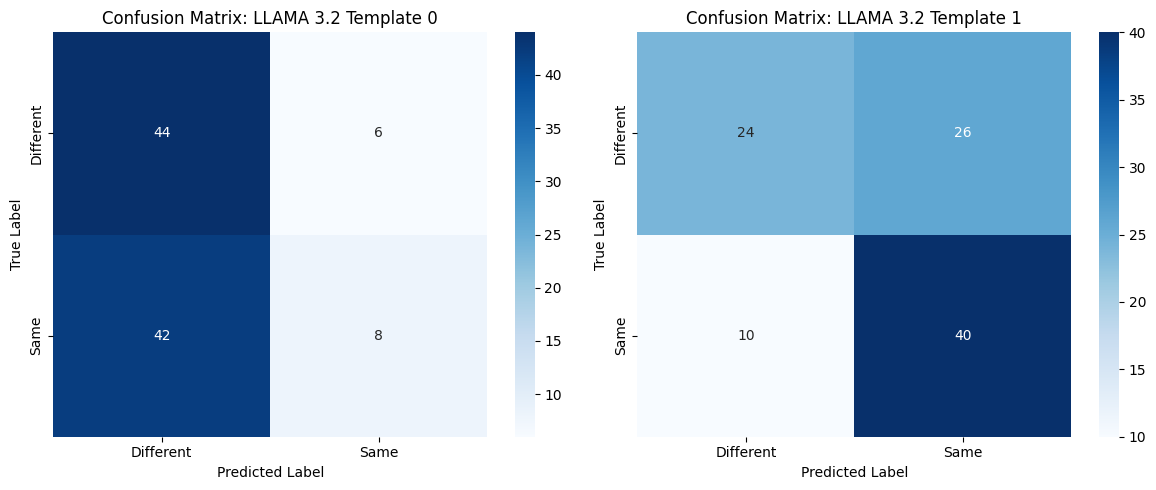

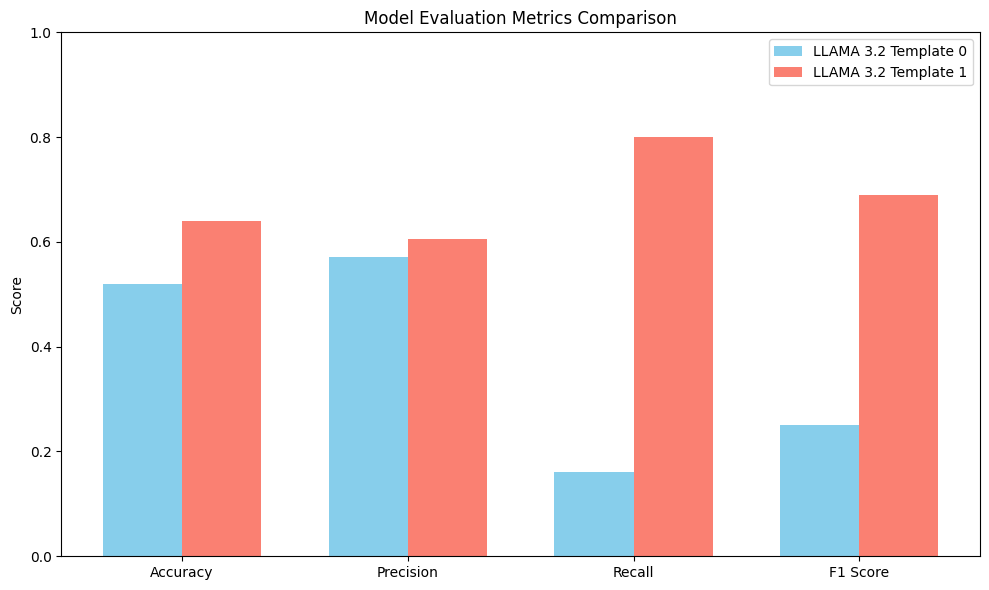

LLAMA 3.2 Template 0 Metrics:
  Accuracy: 0.52, Precision: 0.57, Recall: 0.16, F1 Score: 0.25
LLAMA 3.2 Template 1 Metrics:
  Accuracy: 0.64, Precision: 0.61, Recall: 0.80, F1 Score: 0.69


((0.52, 0.5714285714285714, 0.16, 0.25),
 (0.64, 0.6060606060606061, 0.8, 0.6896551724137931))

In [52]:
evaluate_models(true_labels, predictions_l_0, predictions_l_1, template1_name="LLAMA 3.2 Template 0", template2_name="LLAMA 3.2 Template 1")

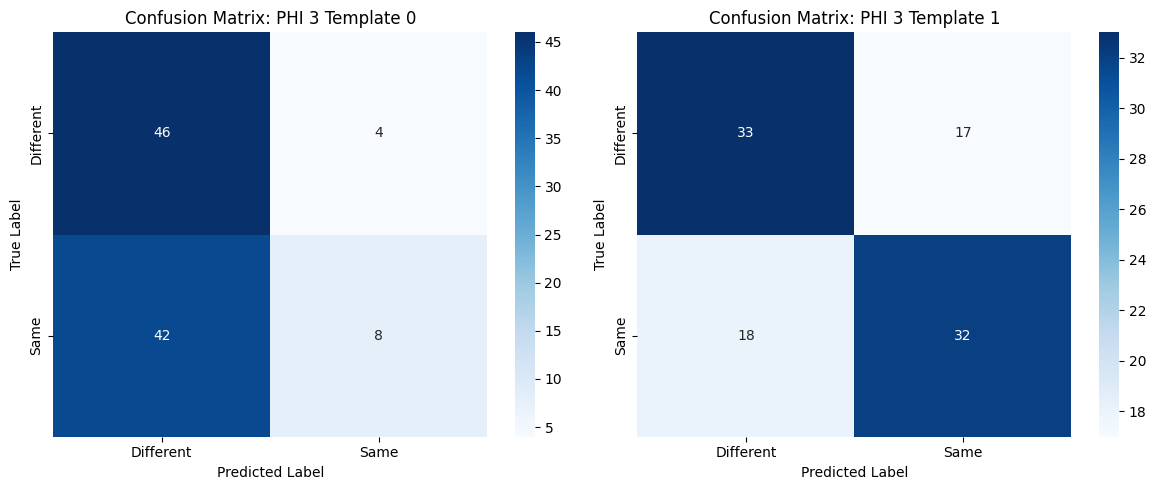

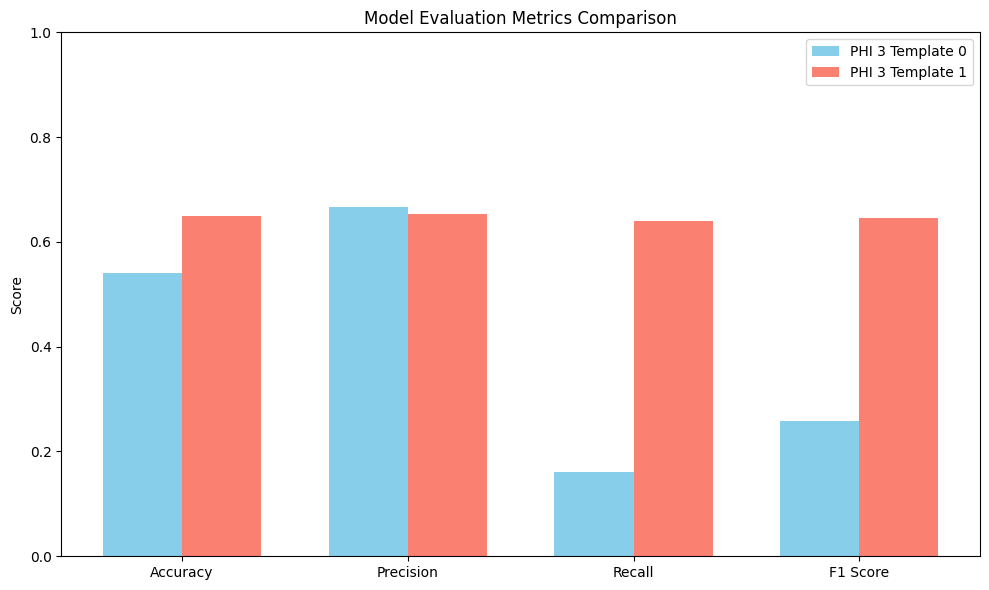

PHI 3 Template 0 Metrics:
  Accuracy: 0.54, Precision: 0.67, Recall: 0.16, F1 Score: 0.26
PHI 3 Template 1 Metrics:
  Accuracy: 0.65, Precision: 0.65, Recall: 0.64, F1 Score: 0.65


((0.54, 0.6666666666666666, 0.16, 0.25806451612903225),
 (0.65, 0.6530612244897959, 0.64, 0.6464646464646465))

In [53]:
evaluate_models(true_labels, predictions_p_0, predictions_p_1, template1_name="PHI 3 Template 0", template2_name="PHI 3 Template 1")

### Playing with embeddings

In [55]:
def get_embeddings_for_probing(samples):
    client = OpenAI()
    embeddings_data = []
    
    for sample in samples:
        # get embeddings for each sentence using text-embedding-ada-002
        sentence1_embedding = client.embeddings.create(
            input=sample['sentence1'],
            model="text-embedding-ada-002"
        ).data[0].embedding
        
        sentence2_embedding = client.embeddings.create(
            input=sample['sentence2'],
            model="text-embedding-ada-002"
        ).data[0].embedding
        
        embeddings_data.append({
            'word': sample['word'],
            'embeddings': (sentence1_embedding, sentence2_embedding),
            'label': sample['true_label']   
        })
    
    return embeddings_data

def get_embeddings_for_probing_ollama(samples, Model="llama3.2"):
    embeddings_data = []

    for sample in  tqdm(samples, desc=f"get Embedding: {Model}", smoothing=0):
        print(f"Processing word: {sample['word']}")
        sentence1_embedding = ollama.embeddings(model=Model, prompt=sample['sentence1'])["embedding"]
        sentence2_embedding = ollama.embeddings(model=Model, prompt=sample['sentence2'])["embedding"]
        embeddings_data.append({
            'word': sample['word'],
            'embeddings': (sentence1_embedding, sentence2_embedding),
            'label': sample['true_label']   
        })
    return embeddings_data    

In [37]:
"""llama_embeddings_data = get_embeddings_for_probing_ollama(samples, Model="llama3.2")
#save embedding in json file
json.dump(llama_embeddings_data, open('llama3-2_embeddings_data.json', 'w'), indent=4)"""


Processing word: credit
Processing word: night
Processing word: fit


In [118]:
"""phi_embeddings_data = get_embeddings_for_probing_ollama(samples, Model="phi3")
#save embedding in json file
json.dump(phi_embeddings_data, open('phi3_embeddings_data.json', 'w'), indent=4)"""

'phi_embeddings_data = get_embeddings_for_probing_ollama(samples, Model="phi3")\n#save embedding in json file\njson.dump(phi_embeddings_data, open(\'phi3_embeddings_data.json\', \'w\'), indent=4)'

In [56]:
phi_embeddings_data = json.load(open('phi3_embeddings_data.json'))
llama_embeddings_data = json.load(open('llama3-2_embeddings_data.json'))

In [103]:
def visualize_word_embeddings_2d(embeddings_data, num_samples=5):
    X = np.array([np.concatenate(sample['embeddings']) for sample in embeddings_data])[:num_samples]
    labels = np.array([sample['label'] for sample in embeddings_data])
    words = np.array([sample['word'] for sample in embeddings_data])
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(12, 8))    
    for i in range(len(X_pca)):
        circle = plt.Circle((X_pca[i, 0], X_pca[i, 1]), 
                          radius=10,  # Adjust radius as needed
                          color='red' if labels[i] == 1 else 'blue',
                          alpha=0.2)
        plt.gca().add_patch(circle)
        plt.annotate(words[i], 
                    (X_pca[i, 0], X_pca[i, 1]),
                    fontsize=10,
                    ha='center',
                    va='center')
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.title('2D Word Sense Embedding Space')
    
    legend_elements = [Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='red', markersize=10,
                            label='Same Sense'),
                      Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='blue', markersize=10,
                            label='Different Sense')]
    plt.legend(handles=legend_elements)
    plt.gca().set_aspect('equal')
    plt.margins(0.2)
    plt.tight_layout()
    
    return pca, plt.gcf()

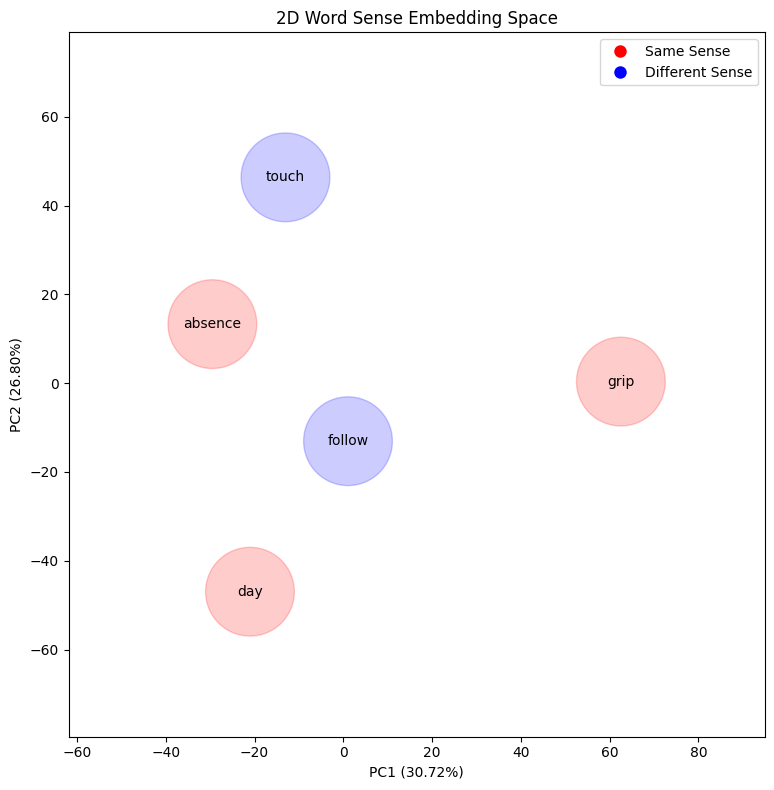

In [104]:
pca_model, fig = visualize_word_embeddings_2d(llama_embeddings_data)
plt.show()

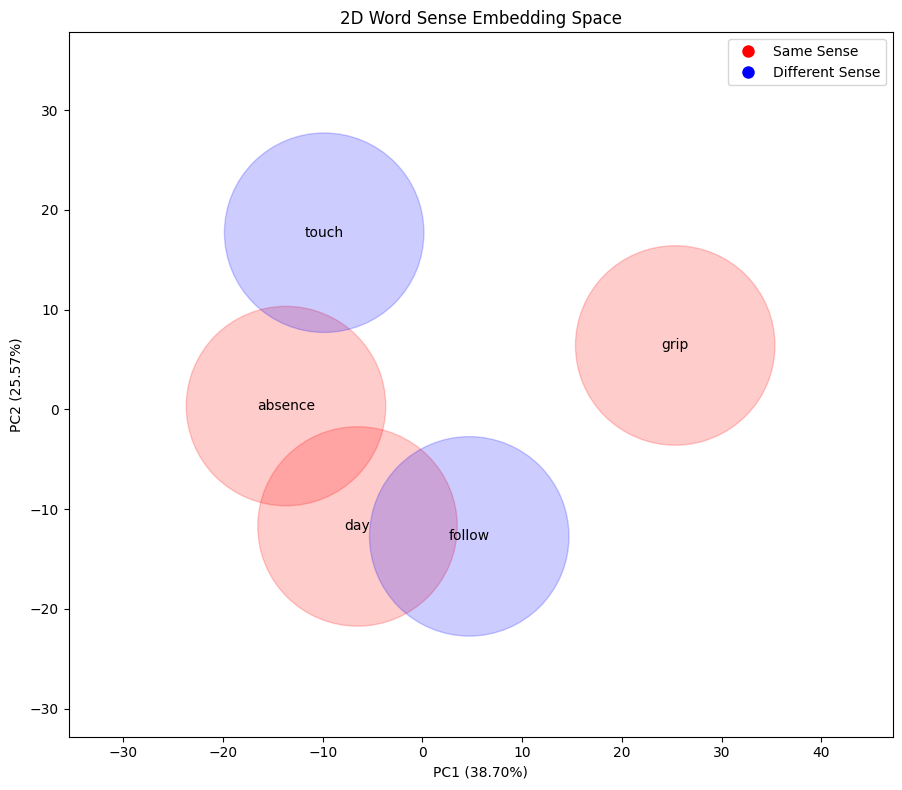

In [108]:
pca_model, fig = visualize_word_embeddings_2d(phi_embeddings_data)
plt.show()

In [105]:
def visualize_word_embeddings_3d_static(embeddings_data, views=[(30, 45), (30, 135), (30, 225), (30, 315)], num_samples=5):
    X = np.array([np.concatenate(sample['embeddings']) for sample in embeddings_data])[:num_samples]
    labels = np.array([sample['label'] for sample in embeddings_data])
    words = np.array([sample['word'] for sample in embeddings_data])
    
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    
    fig = plt.figure(figsize=(20, 5))
    
    for idx, (elev, azim) in enumerate(views, 1):
        ax = fig.add_subplot(1, len(views), idx, projection='3d')
        
        ax.quiver(0, 0, 0, 1, 0, 0, color='r', alpha=0.5, lw=2)
        ax.quiver(0, 0, 0, 0, 1, 0, color='g', alpha=0.5, lw=2)
        ax.quiver(0, 0, 0, 0, 0, 1, color='b', alpha=0.5, lw=2)
        
        colors = plt.cm.rainbow(np.linspace(0, 1, len(X_pca)))
        for i, (point, word, color) in enumerate(zip(X_pca, words, colors)):
            ax.quiver(0, 0, 0, point[0], point[1], point[2],
                     color=color, alpha=0.6)
            
            ax.text(point[0], point[1], point[2], 
                    word,
                    color=color,
                    fontsize=10)
        
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.set_box_aspect([1,1,1])
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])        
        ax.grid(True, alpha=0.3)
        ax.set_title(f'View from {azim}°')
    
    plt.suptitle('Word Embeddings Visualization - Multiple Views', y=1.05)
    plt.tight_layout()
    return pca, fig

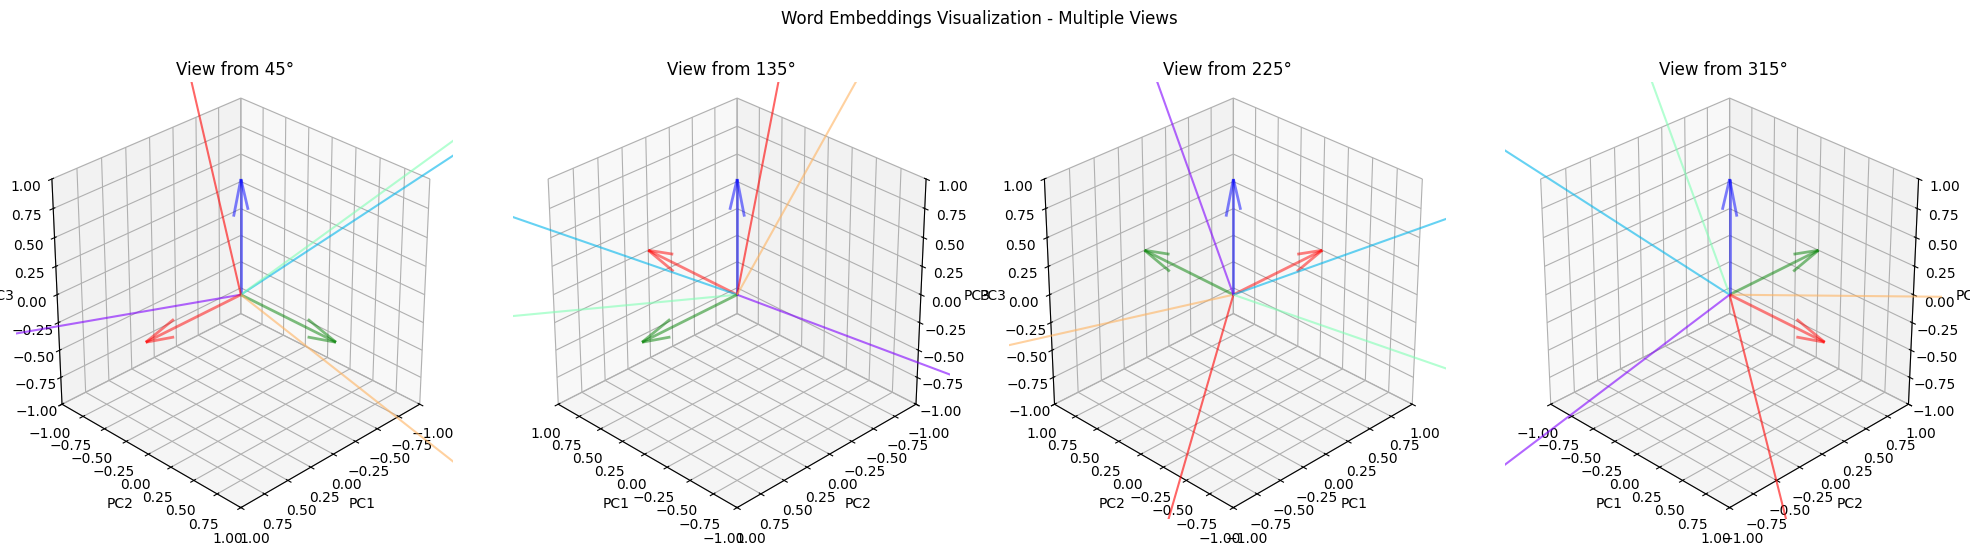

In [106]:
visualize_word_embeddings_3d_static(llama_embeddings_data)
plt.show()

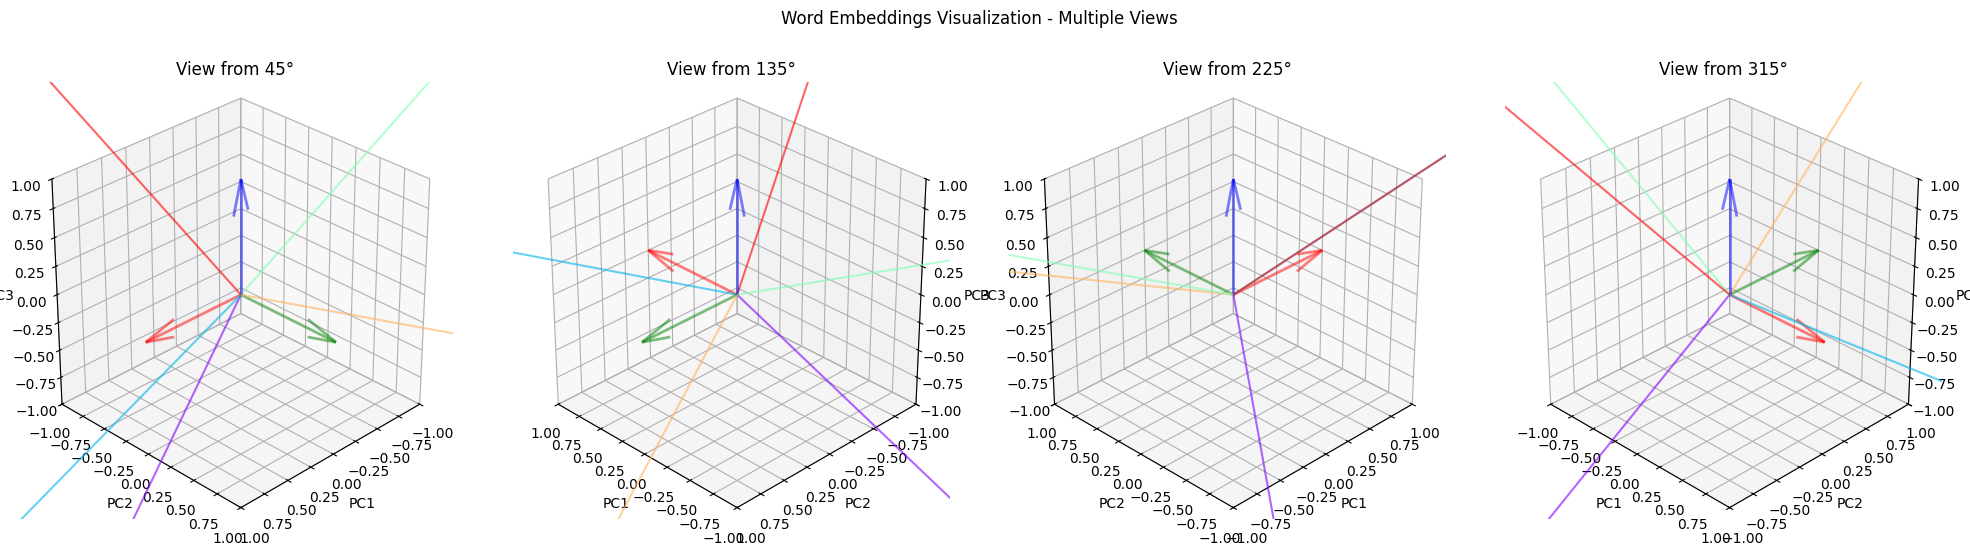

In [107]:
visualize_word_embeddings_3d_static(phi_embeddings_data)
plt.show()

In [114]:
def visualize_sentence_embeddings_comparison(embeddings_data, num_samples=5):
    embeddings_data = embeddings_data[:num_samples]
    sentences1_embeddings = np.array([sample['embeddings'][0] for sample in embeddings_data])
    sentences2_embeddings = np.array([sample['embeddings'][1] for sample in embeddings_data])
    labels = np.array([sample['label'] for sample in embeddings_data])
    words = np.array([sample['word'] for sample in embeddings_data])
    all_embeddings = np.vstack([sentences1_embeddings, sentences2_embeddings])
    
    pca = PCA(n_components=3)
    all_embeddings_pca = pca.fit_transform(all_embeddings)
    
    n_samples = len(embeddings_data)
    sent1_pca = all_embeddings_pca[:n_samples]
    sent2_pca = all_embeddings_pca[n_samples:]
    
    fig = plt.figure(figsize=(20, 5))
    views = [(30, 45), (30, 135), (30, 225), (30, 315)]
    
    for idx, (elev, azim) in enumerate(views, 1):
        ax = fig.add_subplot(1, len(views), idx, projection='3d')
        
        for i in range(n_samples):
            ax.plot([sent1_pca[i, 0], sent2_pca[i, 0]],
                   [sent1_pca[i, 1], sent2_pca[i, 1]],
                   [sent1_pca[i, 2], sent2_pca[i, 2]],
                   color='red' if labels[i] == 1 else 'blue',
                   alpha=0.5,
                   linestyle='--')
            
            ax.scatter(sent1_pca[i, 0], sent1_pca[i, 1], sent1_pca[i, 2],
                      color='red' if labels[i] == 1 else 'blue',
                      marker='o')
            ax.scatter(sent2_pca[i, 0], sent2_pca[i, 1], sent2_pca[i, 2],
                      color='red' if labels[i] == 1 else 'blue',
                      marker='^')
            ax.text(sent1_pca[i, 0], sent1_pca[i, 1], sent1_pca[i, 2],
                   f'{words[i]}_1', fontsize=8)
            ax.text(sent2_pca[i, 0], sent2_pca[i, 1], sent2_pca[i, 2],
                   f'{words[i]}_2', fontsize=8)
        
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(f'View from {elev}°, {azim}°')
        
    plt.suptitle('Sentence Embeddings Comparison\nRed: Same Sense, Blue: Different Sense')
    plt.tight_layout()
    
    # legend
    handles = [
        plt.Line2D([0], [0], color='red', label='Same Sense'),
        plt.Line2D([0], [0], color='blue', label='Different Sense'),
        plt.Line2D([0], [0], marker='o', color='gray', label='Sentence 1', linestyle='None'),
        plt.Line2D([0], [0], marker='^', color='gray', label='Sentence 2', linestyle='None')
    ]
    fig.legend(handles=handles, loc='center right')
    
    return pca, fig

In [115]:
def visualize_target_word_embeddings(embeddings_data, num_samples=5):
    """
    Visualize embeddings for the target word in both sentences.
    Red for same sense, Blue for different sense.
    """
    embeddings_data = embeddings_data[:num_samples]
    target_words = np.array([sample['word'] for sample in embeddings_data])
    labels = np.array([sample['label'] for sample in embeddings_data])
    word1_embeddings = np.array([sample['embeddings'][0] for sample in embeddings_data])
    word2_embeddings = np.array([sample['embeddings'][1] for sample in embeddings_data])
    all_embeddings = np.vstack([word1_embeddings, word2_embeddings])
    
    pca = PCA(n_components=3)
    all_embeddings_pca = pca.fit_transform(all_embeddings)
    n_samples = len(embeddings_data)
    word1_pca = all_embeddings_pca[:n_samples]
    word2_pca = all_embeddings_pca[n_samples:]
    
    fig = plt.figure(figsize=(20, 5))
    views = [(30, 45), (30, 135), (30, 225), (30, 315)]
    
    for idx, (elev, azim) in enumerate(views, 1):
        ax = fig.add_subplot(1, len(views), idx, projection='3d')
        
        for i in range(n_samples):
            color = 'red' if labels[i] == 1 else 'blue'
            
            ax.plot([word1_pca[i, 0], word2_pca[i, 0]],
                   [word1_pca[i, 1], word2_pca[i, 1]],
                   [word1_pca[i, 2], word2_pca[i, 2]],
                   color=color, alpha=0.5, linestyle='--')
            
            ax.scatter(word1_pca[i, 0], word1_pca[i, 1], word1_pca[i, 2],
                      color=color, marker='o')
            ax.scatter(word2_pca[i, 0], word2_pca[i, 1], word2_pca[i, 2],
                      color=color, marker='^')
            ax.text(word1_pca[i, 0], word1_pca[i, 1], word1_pca[i, 2],
                   f'{target_words[i]}_ctx1', fontsize=8)
            ax.text(word2_pca[i, 0], word2_pca[i, 1], word2_pca[i, 2],
                   f'{target_words[i]}_ctx2', fontsize=8)
        
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(f'View from {elev}°, {azim}°')
        ax.set_box_aspect([1,1,1])
        
    plt.suptitle('Target Word Embeddings in Different Contexts\nRed: Same Sense, Blue: Different Sense')
    
    # legend
    handles = [
        plt.Line2D([0], [0], color='red', label='Same Sense'),
        plt.Line2D([0], [0], color='blue', label='Different Sense'),
        plt.Line2D([0], [0], marker='o', color='gray', label='Context 1', linestyle='None'),
        plt.Line2D([0], [0], marker='^', color='gray', label='Context 2', linestyle='None')
    ]
    fig.legend(handles=handles, loc='center right')
    
    plt.tight_layout()
    return pca, fig

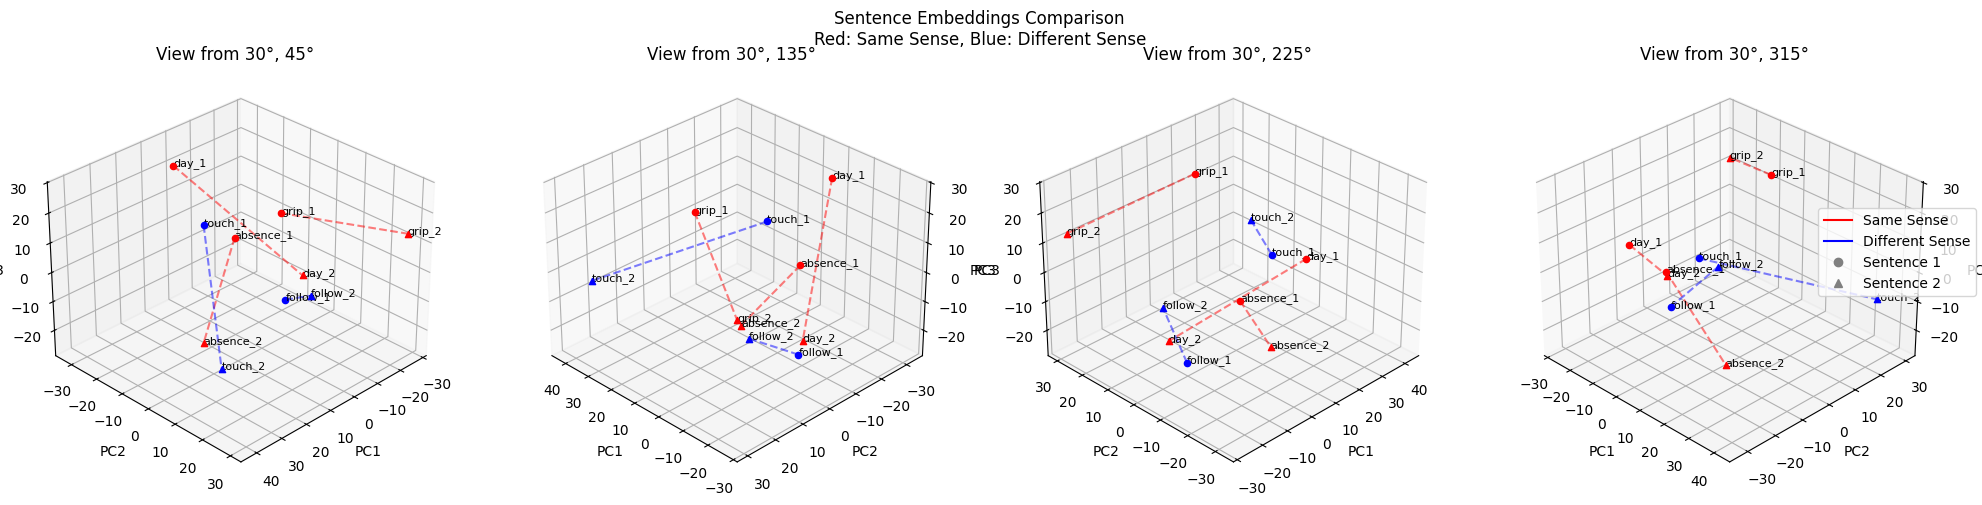

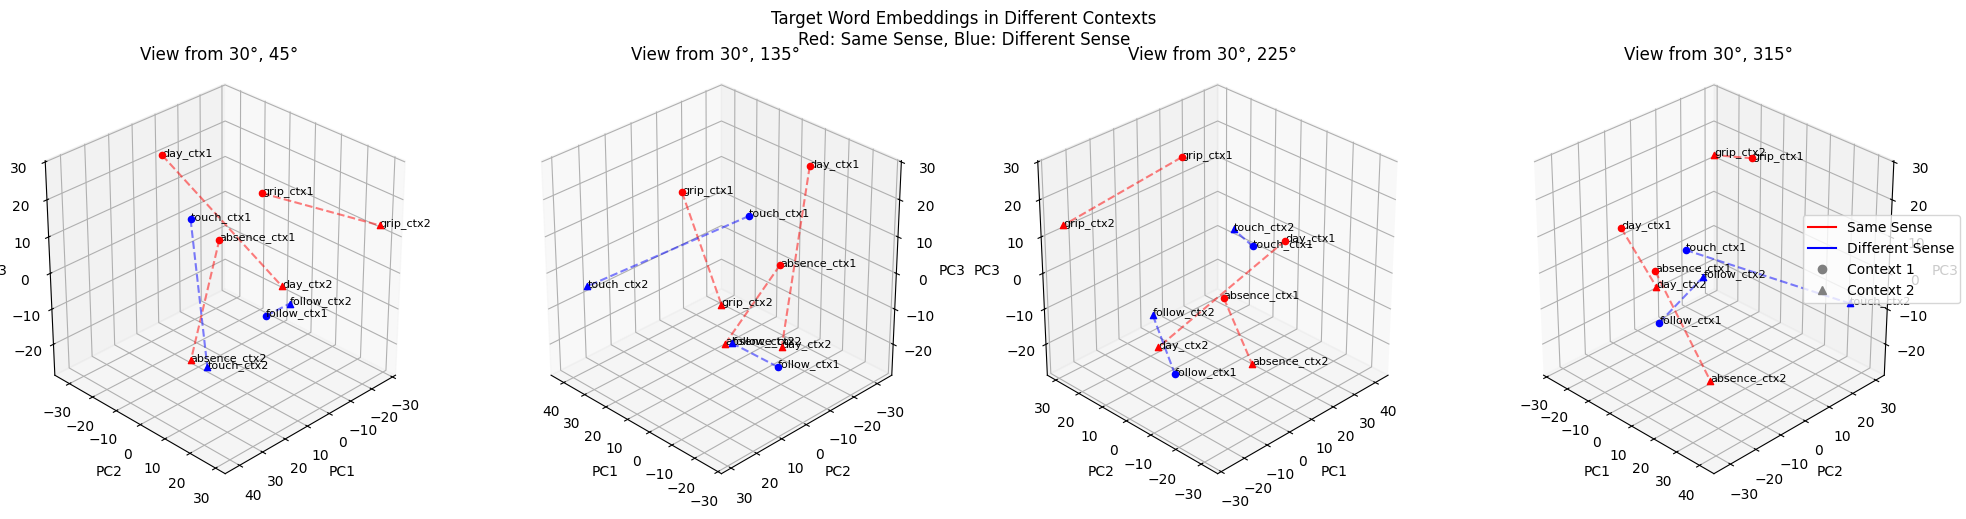

In [116]:
pca_model_sentences, fig_sentences = visualize_sentence_embeddings_comparison(llama_embeddings_data)
pca_model_target_word, fig_target_word = visualize_target_word_embeddings(llama_embeddings_data)
plt.show()

c:\Users\amine\anaconda3\envs\ai-guardians\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


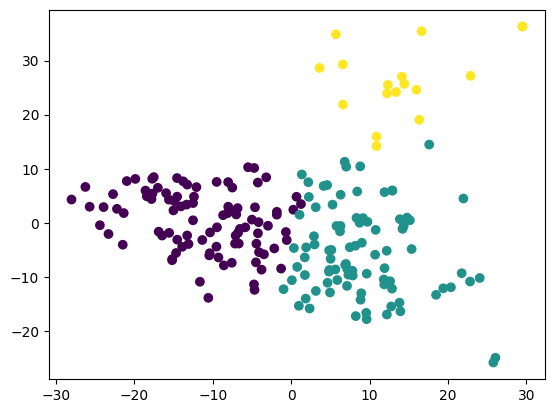

In [117]:
def analyze_sense_clusters(embeddings_data):
    from sklearn.cluster import KMeans
    
    all_embeddings = np.vstack([emb for sample in embeddings_data 
                               for emb in sample['embeddings']])
    
    kmeans = KMeans(n_clusters=3)
    clusters = kmeans.fit_predict(all_embeddings)
    
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(all_embeddings)
    
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                c=clusters, cmap='viridis')
analyze_sense_clusters(llama_embeddings_data)

In [71]:


def visualize_cosine_similarity(embeddings_data, Model=None):
    """ 
    Calculate cosine similarity between sentence embeddings and visualize the results 
    Cosine values range from -1 to 1, where 1 indicates identical vectors and -1 indicates opposite vectors.
    Similarity values close to 1 indicate that the sentences are similar, while values close to -1 indicate dissimilarity.
    """

    similarities = []
    for sample in embeddings_data:
        emb1, emb2 = sample['embeddings']
        similarity = cosine_similarity([emb1], [emb2])[0][0]
        similarities.append(similarity)
    
    labels = [sample['label'] for sample in embeddings_data]

    # Separate similarities into "same" and "different" based on labels
    same_similarities = [sim for sim, label in zip(similarities, labels) if label == 1]
    diff_similarities = [sim for sim, label in zip(similarities, labels) if label == 0]

    # Calculate statistics
    stats = {
        'same': {
            'min': np.min(same_similarities),
            'max': np.max(same_similarities),
            'mean': np.mean(same_similarities),
            'std': np.std(same_similarities),
        },
        'diff': {
            'min': np.min(diff_similarities),
            'max': np.max(diff_similarities),
            'mean': np.mean(diff_similarities),
            'std': np.std(diff_similarities),
        }
    }

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].scatter([0] * len(same_similarities), same_similarities, color='red', alpha=0.6, label='Same Sense')
    axs[0].scatter([1] * len(diff_similarities), diff_similarities, color='blue', alpha=0.6, label='Different Sense')
    axs[0].set_xticks([0, 1])
    axs[0].set_xticklabels(['Same Sense', 'Different Sense'])
    axs[0].set_xlabel('Label')
    axs[0].set_ylabel('Cosine Similarity')
    axs[0].set_title(f'Cosine Similarity Between Sentence Embeddings Model: {Model}')
    axs[0].legend()

    data = [same_similarities, diff_similarities]
    box = axs[1].boxplot(data, patch_artist=True, vert=True, showmeans=True, showfliers=False, widths=0.6)

    for i, label in enumerate(['Same Sense', 'Different Sense']):
        axs[1].text(i + 1, stats['same' if i == 0 else 'diff']['mean'] + 0.02, f"Mean: {stats['same' if i == 0 else 'diff']['mean']:.2f}\n"
                                               f"Std: {stats['same' if i == 0 else 'diff']['std']:.2f}",
                    color='black', fontsize=10, ha='center')

    axs[1].set_xticklabels(['Same Sense', 'Different Sense'])
    axs[1].set_title(f'Cosine Similarity Statistics Model: {Model}') 

    plt.tight_layout()
    plt.show()


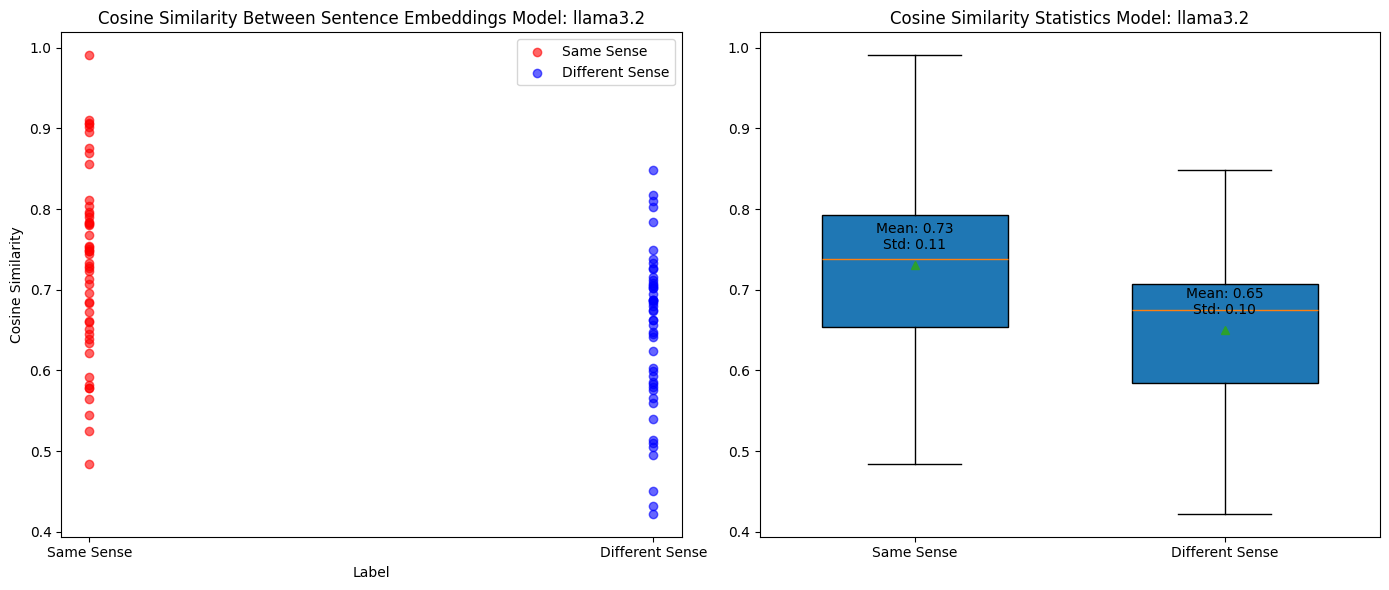

In [72]:
visualize_cosine_similarity(llama_embeddings_data ,Model = "llama3.2")

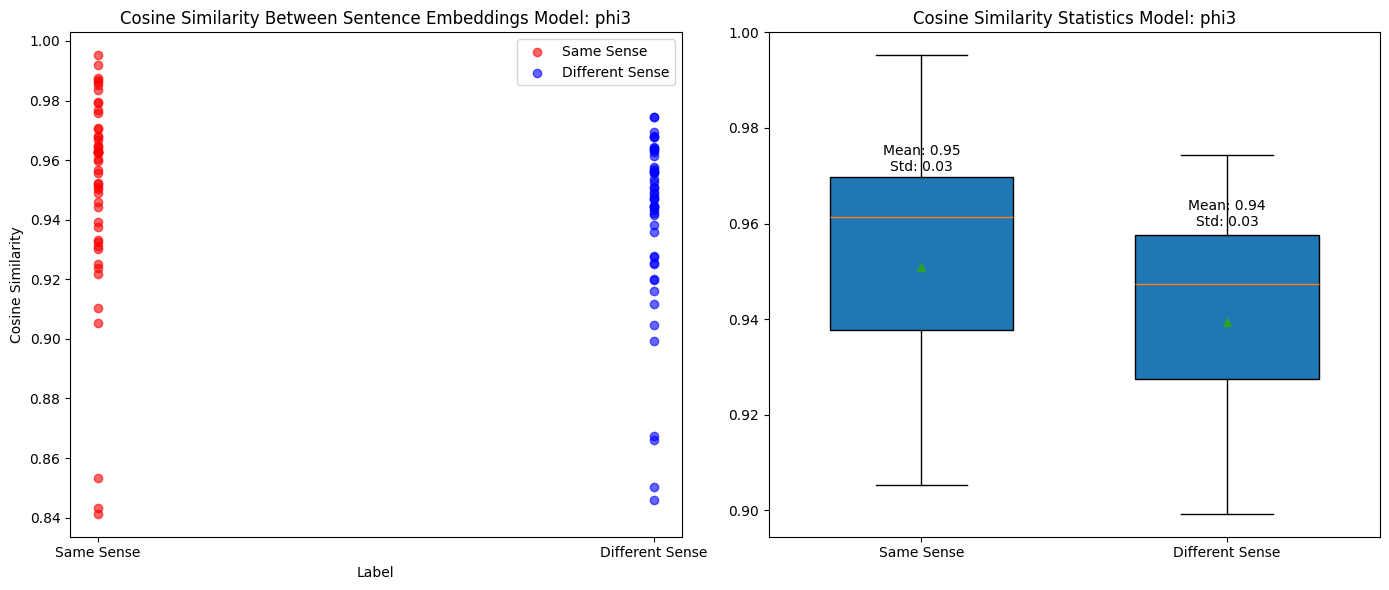

In [73]:
visualize_cosine_similarity(phi_embeddings_data, Model= "phi3")